# RAG 시스템 구축 실습

## 학습 목표
- 웹 문서를 활용한 RAG(Retrieval-Augmented Generation) 시스템 구축
- 문서 로딩부터 질의응답까지 전체 파이프라인 이해
- LangChain과 Ollama를 활용한 실제 구현 실습



In [ ]:
import bs4
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_ollama import OllamaEmbeddings, OllamaLLM

## 2. 문서 로딩 (Document Loading)

**주요 포인트:**
- `web_paths`: 로딩할 웹 페이지 URL
- `bs_kwargs`: BeautifulSoup 파싱 옵션
- `SoupStrainer`: 특정 HTML 요소만 추출 (불필요한 내용 제거)

In [2]:
# 1. 문서 로딩 (Document Loading)
loader = WebBaseLoader(
    web_paths=("https://www.bbc.com/korean/articles/cl4yml4l6j1o",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            "div",
            attrs={"class": ["bbc-1cvxiy9", "bbc-fa0wmp"]},
        )
    ),
)
docs = loader.load()
print(f"문서의 수: {len(docs)}")

문서의 수: 1


## 3. 문서 분할 (Document Splitting)

- `chunk_size=500`: 각 청크의 최대 크기 (문자 수)
- `chunk_overlap=50`: 청크 간 중복되는 문자 수 (문맥 보존)
- 분할 이유: LLM의 토큰 제한, 검색 정확도 향상

In [3]:
# 2. 문서 분할 (Splitting)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = text_splitter.split_documents(docs)
print(f"split size: {len(splits)}")

split size: 9


## 4. 임베딩 및 벡터 저장소 구축

- `OllamaEmbeddings`: 텍스트를 벡터로 변환
- `FAISS`: Facebook이 개발한 효율적인 벡터 검색 라이브러리
- `retriever`: 질문과 유사한 문서 조각을 찾는 검색기

In [4]:
# 3. 임베딩 생성 (Embedding)
embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")

# 4. 벡터 저장소 구축 (Vector Database)
vector_store = FAISS.from_documents(documents=splits, embedding=embeddings)

# 4-1. 쿼리 저장소 검색을 위한 retriever 생성
retriever = vector_store.as_retriever()

## 5. 프롬프트 템플릿 설정

**프롬프트 설계 원칙:**
- 명확한 역할 정의
- 문맥 기반 답변 지시
- 모르는 것은 모른다고 답하도록 유도
- 추측이나 환각 방지

In [5]:
# PROMPT Template 생성
prompt = PromptTemplate.from_template(
"""당신은 질문-답변(Question-Answering)을 수행하는 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
질문과 관련성이 높은 내용만 답변하고 추측된 내용을 생성하지 마세요. 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question} 

#Context: 
{context} 

#Answer:"""
)

## 6. LLM 초기화 및 체인 생성

- `temperature=0`: 일관된 답변을 위해 창의성 최소화
- `chain`: 프롬프트 → LLM → 출력 파싱의 파이프라인
- `|` 연산자: LangChain의 체인 연결 문법

In [6]:
# Ollama 초기화
llm = OllamaLLM(
    model="exaone3.5:7.8b",
    temperature=0
)

# 체인을 생성합니다.
chain = prompt | llm | StrOutputParser()

## 7. 질의응답 실행

**실행 과정:**
1. **문서 검색**: 질문과 관련된 문서 조각들을 벡터 DB에서 검색
2. **문맥 결합**: 검색된 여러 문서를 하나의 문맥으로 결합
3. **프롬프트 생성**: 질문과 문맥을 템플릿에 삽입
4. **스트리밍 답변**: 실시간으로 답변을 생성하고 출력

In [7]:
# 테스트 할 질문
question = "극한 호우의 원인은 무엇인가?"

# 5. 쿼리 처리 (Query-Retriever) : 벡터 DB 에서 참고할 문서 검색
retrieved_docs = retriever.invoke(question)
print(f"retrieved size: {len(retrieved_docs)}")

# 검색된 문서들을 하나의 문자열로 결합
combined_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)

# 6. 검색된 문서를 첨부해서 PROMPT 생성
formatted_prompt = {"context": combined_docs, "question": question}

# 7. LLM에 질문
for chunk in chain.stream(formatted_prompt):
    print(chunk, end="", flush=True)

retrieved size: 4
극한 호우의 주요 원인은 다음과 같습니다:

1. **저기압 시스템**: 문맥에서 여러 전문가들이 저기압이 집중 호우의 직접적인 원인이라고 언급했습니다. 특히, 서해에서 유입된 저기압이 장마전선과 결합하여 많은 비를 내렸다고 설명했습니다.

2. **기후 변화**: 해수면 온도 상승과 같은 기후 변화 요인이 강우 패턴에 영향을 미칠 수 있습니다. 서해의 표층 수온 상승이 빠르게 진행되고 있으며, 이는 극단적인 강수 이벤트와 연관될 수 있습니다.

3. **대기 순환 패턴 변화**: 온난화로 인해 대기 순환 패턴이 변화하여 짧은 시간 동안 집중적으로 비가 내리는 경향이 증가하고 있습니다.

이러한 요인들이 복합적으로 작용하여 극한 호우를 초래한다고 볼 수 있습니다.

## 실습: 청크 크기 변경에 따른 답변 품질 비교
### 문서를 분리할때 `chunk_size=500`, `chunk_overlap=50`가 아닌   `chunk_size=1000`, `chunk_overlap=100`으로 설정하고 동일한 질문에 대해 답변 품질 차이를 확인해보세요.

In [8]:

# ################청크 사이즈 변경 후
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=____, #1000
    chunk_overlap=___ #100
)

#####################
splits = text_splitter.split_documents(docs)
print(f"split size: {len(splits)}")

# 벡터 저장소를 새로 구축
vector_store = FAISS.from_documents(documents=splits, embedding=embeddings)
retriever = vector_store.as_retriever()  # 새로운 retriever 생성

# 이제 질문 처리
question = "극한 호우의 원인은 무엇인가?"
retrieved_docs = retriever.invoke(question)

# 테스트 할 질문
question = "극한 호우의 원인은 무엇인가?"

# 5. 쿼리 처리 (Query-Retriever) : 벡터 DB 에서 참고할 문서 검색
retrieved_docs = retriever.invoke(question)
print(f"retrieved size: {len(retrieved_docs)}")

# 검색된 문서들을 하나의 문자열로 결합
combined_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)

# 6. 검색된 문서를 첨부해서 PROMPT 생성
formatted_prompt = {"context": combined_docs, "question": question}

# 7. LLM에 질문
for chunk in chain.stream(formatted_prompt):
    print(chunk, end="", flush=True)

split size: 5
retrieved size: 4
극한 호우의 원인은 복합적이지만 주요 요인들은 다음과 같습니다:

1. **기후 변화**: 지구 온난화로 인해 해수면 온도가 상승하고 대기 중 수증기 함량이 증가합니다. 이로 인해 더 강력하고 집중적인 강수 현상이 발생할 수 있습니다. 특히 서해의 빠른 온난화는 이러한 변화에 영향을 미칠 수 있습니다.

2. **저기압 시스템**: 강한 저기압 시스템이 발달하여 북태평양 고기압과 충돌하면서 많은 양의 강수를 유발합니다. 저기압의 크기와 강도가 커지면서 중규모 저기압이 장마전선과 결합하여 집중호우를 일으킵니다.

3. **대기 순환 패턴 변화**: 온난화로 인해 대기 순환 패턴이 변화하여 예상치 못한 강수 패턴이 나타나고 있습니다. 이 변화는 과거에는 드물었던 시간당 100mm 이상의 폭우를 더 자주 발생시키는 요인 중 하나입니다.

4. **해양 온도 상승**: 특히 서해안의 빠른 온난화는 대기와 해양 사이의 열 교환을 변화시켜 강수 패턴에 영향을 미칠 수 있습니다.

이러한 요인들이 복합적으로 작용하여 극한 호우 현상이 증가하고 있는 것으로 보입니다.

# 고급 RAG 시스템 - 벡터 DB 저장 및 대화형 실습

## 학습 목표
- 벡터 DB를 로컬에 저장하고 재사용하는 방법 학습
- PDF 문서를 활용한 RAG 시스템 구축
- 대화형 질의응답 시스템 구현
- 성능 최적화를 위한 벡터 DB 관리

## 새로운 특징
- **벡터 DB 저장**: 한 번 생성한 벡터 DB를 파일로 저장하고 재사용
- **PDF 문서 처리**: 웹 페이지 대신 PDF 파일을 데이터 소스로 활용
- **대화형 인터페이스**: 여러 질문을 연속으로 처리하는 채팅 시스템

## 1. 라이브러리 import 및 설정

**새로운 라이브러리:**
- `PyPDFLoader`: PDF 파일에서 텍스트 추출
- `FAISS`: Facebook AI Similarity Search - 대용량 벡터 검색을 위한 고성능 라이브러리

In [4]:
import os
import time
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain_ollama import OllamaEmbeddings, OllamaLLM

# 벡터 DB 파일 경로
VECTOR_DB_PATH = "faiss_index"

## 2. 벡터 DB 생성 함수

**핵심 개념:**
- `PyPDFLoader`: PDF 파일에서 페이지별로 텍스트 추출
- `chunk_size=700, chunk_overlap=70`: 이전보다 큰 청크 크기 사용
- `save_local()`: 생성된 벡터 DB를 디스크에 저장

In [2]:
def create_vector_db():
    # 1-1. 문서 로딩 (Document Loading)
    loader = PyPDFLoader("./document/news_weather.pdf")
    
    docs = loader.load()
    print(f"문서의 수: {len(docs)}")
    
    # 1-2. 문서 분할 (Splitting)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=70)
    splits = text_splitter.split_documents(docs)
    print(f"split size: {len(splits)}")
    
    # 1-3. 임베딩 생성 (Embedding)
    embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")
    
    # 1-4. 벡터 저장소 구축 (Vector Database)
    vector_store = FAISS.from_documents(
        documents=splits, 
        embedding=embeddings, 
    )
    
    # 1-5. 벡터 DB를 로컬에 저장
    vector_store.save_local(VECTOR_DB_PATH)
    
    return vector_store

## 3. 벡터 DB 로딩 메인 로직


- `os.path.exists()`: 기존 벡터 DB 파일 존재 여부 확인
- **첫 실행**: 벡터 DB 생성 → 시간이 오래 걸림
- **재실행**: 기존 벡터 DB 로딩 → 빠른 시작


In [3]:
start_time = time.time()  # 시작 시간 기록

if os.path.exists(VECTOR_DB_PATH):
    print("기존 벡터 DB를 로드합니다.")
    embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")
    vector_store = FAISS.load_local(
        VECTOR_DB_PATH, 
        embeddings, 
        allow_dangerous_deserialization=True # 믿을 수 있는 소스임을 확인
    )
else:
    print("새로운 벡터 DB를 생성합니다.")
    vector_store = create_vector_db()

end_time = time.time()  # 끝 시간 기록
time_taken = end_time - start_time
print(f"벡터 DB 생성 소요 시간: {time_taken:.2f}초")

새로운 벡터 DB를 생성합니다.
문서의 수: 10
split size: 17
벡터 DB 생성 소요 시간: 8.32초


## 4. 대화형 질의응답 시스템

**대화형 시스템 특징:**
- `while True`: 무한 루프로 연속 질문 처리
- `input()`: 사용자 입력 대기
- **종료 조건**: "끝" 또는 "exit" 입력 시 프로그램 종료
- **실시간 답변**: 스트리밍 방식으로 답변을 실시간 출력

In [ ]:
# 3. retriever 및 체인 설정
retriever = vector_store.as_retriever()

prompt = PromptTemplate.from_template(
"""당신은 질문-답변(Question-Answering)을 수행하는 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
질문과 관련성이 높은 내용만 답변하고 추측된 내용을 생성하지 마세요. 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question}

#Context: 
{context} 

#Answer:"""
)

llm = OllamaLLM(model="exaone3.5:7.8b", temperature=0)
chain = prompt | llm | StrOutputParser()

# 7. 대화형 질의응답 루프
while True:
    # 7-1. 사용자의 입력을 기다림
    question = input("\n\n당신: ")
    if question == "끝" or question == "exit":
        break
        
    # 7-2. 쿼리 처리 (Query-Retriever)
    retrieved_docs = retriever.invoke(question)
    print(f"retrieved size: {len(retrieved_docs)}")
    combined_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)
    
    # 7-3. 프롬프트 생성 및 실행
    formatted_prompt = {"context": combined_docs, "question": question}
    
    # 7-4. 스트리밍 답변
    result = ""
    for chunk in chain.stream(formatted_prompt):
        print(chunk, end="", flush=True)
        result += chunk



당신:  여름철 질식사고에는 어떤 종류가 있지?


retrieved size: 4
주어진 문맥에서 여름철 질식사고의 구체적인 종류에 대해서는 명시적으로 다루고 있지 않습니다. 주로 어린이가 차량 내에서 발생할 수 있는 위험과 열사병으로 인한 사망 사례에 초점을 맞추고 있습니다. 따라서, 제공된 정보만으로는 여름철 질식사고의 다양한 종류를 상세히 나열하기 어렵습니다. 

그러나 문맥에서 언급된 관련 내용은 다음과 같습니다:
- **차량 내 열사병으로 인한 질식 위험**: 여름철 차량 내부 온도 상승으로 인한 어린이의 열사병 및 질식 위험.

더 구체적인 질식사고의 종류에 대해서는 주어진 정보에서 명확히 파악할 수 없습니다. 따라서,

**주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다**.



당신:  여름철 많이 발생하는 안전사고는 뭐가있지?


retrieved size: 4
여름철에 많이 발생하는 안전사고로는 다음과 같은 것들이 있습니다:

1. **어린이 차량 내 열사병 및 질식 사고**: 여름철 더운 날씨로 인해 차량 내부 온도가 급격히 상승하여 어린이가 열사병이나 질식 위험에 노출됩니다. 주어진 사례에서 보듯이, 어린이를 차량에 방치하는 것은 매우 위험합니다.

2. **에어컨 관련 폭발 사고**: 에어컨 수리 중 프레온 가스 누출이나 충전 과정에서의 폭발 사고가 발생할 수 있습니다. 특히 에어컨 가스 주입 초기 단계에서 사고 위험이 높습니다.

3. **가정 내 위생 안전사고**: 식중독 등 위생 관리 부족으로 인한 위험이 증가합니다. 특히 장마철 습기 많은 환경에서는 식중독 위험이 높아집니다.

4. **스프레이 및 가스 관련 폭발 위험**: 차량 내에 보관된 스프레이나 가스 제품이 잘못 사용되거나 발효된 주스 등으로 인해 폭발 위험이 있습니다.

이러한 안전사고들은 여름철 특유의 기후 조건과 관련된 위험 요소들로 인해 발생할 가능성이 높습니다.

# 다중 PDF 문서 처리
- glob.glob(): 파일 패턴 매칭을 통한 다중 파일 검색
- os.path.join(): 운영체제에 독립적인 경로 결합
- metadata 추가: 각 문서의 출처 파일 정보 저장

In [5]:
import glob

def load_multiple_pdfs(folder_path):
    """폴더 내의 모든 PDF 파일을 로드합니다."""
    all_docs = []
    
    # PDF 파일들 찾기
    pdf_files = glob.glob(os.path.join(folder_path, "*.pdf"))
    
    print(f"발견된 PDF 파일들:")
    for pdf_file in pdf_files:
        print(f"  - {os.path.basename(pdf_file)}")
    
    # 각 PDF 파일 로딩
    for pdf_file in pdf_files:
        try:
            loader = PyPDFLoader(pdf_file)
            docs = loader.load()
            
            # 어느 파일에서 온 내용인지 표시하기 위해 메타데이터 추가
            for doc in docs:
                doc.metadata['source_file'] = os.path.basename(pdf_file)
            
            all_docs.extend(docs)
            print(f"'{os.path.basename(pdf_file)}' 로딩 완료 - 페이지 수: {len(docs)}")
            
        except Exception as e:
            print(f"오류: '{pdf_file}' 로딩 실패")
    
    return all_docs

## 향상된 벡터 DB 생성 함수
- 다중 문서 처리: 여러 PDF 파일을 한 번에 처리
- 통합 벡터화: 모든 문서를 하나의 벡터 스토어에 저장
- chunk_size=700, chunk_overlap=70: 적절한 크기로 텍스트 분할

In [6]:
# 폴더 경로 설정
DOCUMENTS_FOLDER = "./document"
VECTOR_DB_PATH = "multi_pdf_db"
def create_vector_db():
    # 다중 문서 로딩
    docs = load_multiple_pdfs(DOCUMENTS_FOLDER)
    print(f"\n총 로드된 페이지 수: {len(docs)}")
    
    # 나머지는 동일
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=70)
    splits = text_splitter.split_documents(docs)
    print(f"분할된 청크 수: {len(splits)}")
    
    embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")
    vector_store = FAISS.from_documents(documents=splits, embedding=embeddings)
    vector_store.save_local(VECTOR_DB_PATH)
    
    return vector_store

## 벡터 DB 로딩/생성 
- 다중 문서 통합: 여러 PDF 파일이 하나의 벡터 DB에 저장됨

In [9]:
# documents 폴더에 여러 PDF 파일을 넣고 실행
start_time = time.time()

if os.path.exists(VECTOR_DB_PATH):
    print("기존 벡터 DB를 로드합니다.")
    embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")
    vector_store = FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)
else:
    print("새로운 벡터 DB를 생성합니다.")
    vector_store = create_vector_db()

end_time = time.time()
print(f"처리 시간: {end_time - start_time:.2f}초")

새로운 벡터 DB를 생성합니다.
발견된 PDF 파일들:
  - news_weather.pdf
  - 여름철_안전사고.pdf
  - 원자력안전관리_설명자료.pdf
'news_weather.pdf' 로딩 완료 - 페이지 수: 3
'여름철_안전사고.pdf' 로딩 완료 - 페이지 수: 10
'원자력안전관리_설명자료.pdf' 로딩 완료 - 페이지 수: 26

총 로드된 페이지 수: 39
분할된 청크 수: 81
처리 시간: 12.86초


In [11]:
# 3. retriever 및 체인 설정
retriever = vector_store.as_retriever()

prompt = PromptTemplate.from_template(
"""당신은 질문-답변(Question-Answering)을 수행하는 AI 어시스턴트입니다. 
당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 
만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 
`주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
질문과 관련성이 높은 내용만 답변하고 추측된 내용을 생성하지 마세요. 
기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question}

#Context: 
{context} 

#Answer:"""
)

llm = OllamaLLM(model="exaone3.5:7.8b", temperature=0)
chain = prompt | llm | StrOutputParser()

# 7. 대화형 질의응답 루프
while True:
    # 7-1. 사용자의 입력을 기다림
    question = input("\n\n당신: ")
    if question == "끝" or question == "exit":
        break
        
    # 7-2. 쿼리 처리 (Query-Retriever)
    retrieved_docs = retriever.invoke(question)
    print(f"retrieved size: {len(retrieved_docs)}")
    combined_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)
    
    # 7-3. 프롬프트 생성 및 실행
    formatted_prompt = {"context": combined_docs, "question": question}
    
    # 7-4. 스트리밍 답변
    result = ""
    for chunk in chain.stream(formatted_prompt):
        print(chunk, end="", flush=True)
        result += chunk



당신:  여름철 질식사고 에 대해 알려줘


retrieved size: 4
여름철 질식사고에 대한 직접적인 언급은 주어진 문맥에서 명확하게 다루어지지 않았습니다. 하지만 여름철 관련 사고의 예시로는 어린이가 자동차 안에 방치되어 열사병으로 인한 사고가 언급되었습니다. 이 사고는 여름철 고온으로 인해 차량 내부 온도가 급격히 상승하여 어린이에게 치명적인 상황을 초래할 수 있음을 보여줍니다. 구체적으로:

- **사고 유형**: 어린이 열사병으로 인한 사망 사고
- **발생 원인**: 여름철 고온으로 차량 내부 온도가 빠르게 상승 (예: 50°C에서 최고 70°C 이상)
- **위험성**: 어린이의 얇은 피부로 인해 짧은 시간 내에도 심각한 열사병 발생 가능
- **통계**: 3년 동안 약 9건의 유사 사고 보고

이 정보는 여름철 고온 환경에서 발생할 수 있는 질식사고의 한 형태를 설명합니다. 다른 유형의 여름철 질식사고에 대한 자세한 정보는 주어진 문맥에서 찾을 수 없습니다.



당신:  극한 호우가 뭐야?


retrieved size: 4
극한 호우는 1시간 동안 강수량이 50mm 이상, 또는 3시간 동안 강수량이 90mm 이상인 매우 집중적인 강수 현상을 의미합니다. 주어진 문맥에서는 극한 호우가 잦아지는 원인에 대해 명확하게 밝혀지지 않았지만, 학계에서는 다음과 같은 요인들을 의심하고 있습니다:

1. **해수면 온도 상승**: 특히 서해안의 온난화가 빠르게 진행되고 있으며, 이는 강우 패턴에 영향을 미칠 수 있습니다. 서해의 표층 수온이 1968년부터 2022년까지 약 1.19도 상승한 것으로 나타났습니다.
   
2. **온난화에 따른 대기 순환 변화**: 온도 상승으로 인해 대기 중 수증기 양이 증가하고, 이로 인해 대기 순환 패턴이 변화하여 극단적인 강수 현상이 발생할 가능성이 제기되고 있습니다.

그러나 정확한 원인은 아직 규명되지 않았으며, 다양한 변수들이 복합적으로 작용하고 있다는 점이 강조되고 있습니다.



당신:  끝


# 실습
아래 경로에 있는 LG관련 PDF문서들을 로드하여 질문에 대한 응답을 확인해보세요.
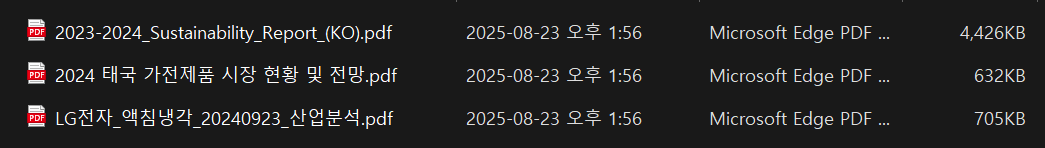

./document_실습용

In [ ]:
# 폴더 경로 설정
DOCUMENTS_FOLDER = "" #경로 설정
VECTOR_DB_PATH = "multi_pdf_ex_db"

# documents 폴더에 여러 PDF 파일을 넣고 실행
start_time = time.time()

if os.path.exists(VECTOR_DB_PATH):
    print("기존 벡터 DB를 로드합니다.")
    embeddings = OllamaEmbeddings(model="exaone3.5:7.8b")
    vector_store = FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)
else:
    print("새로운 벡터 DB를 생성합니다.")
    vector_store = create_vector_db()

end_time = time.time()
print(f"처리 시간: {end_time - start_time:.2f}초")


# 3. retriever 및 체인 설정
retriever = vector_store.as_retriever()

prompt = PromptTemplate.from_template(
"""당신은 질문-답변(Question-Answering)을 수행하는 AI 어시스턴트입니다. 
당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 
만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 
`주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
질문과 관련성이 높은 내용만 답변하고 추측된 내용을 생성하지 마세요. 
기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question}

#Context: 
{context} 

#Answer:"""
)

llm = OllamaLLM(model="exaone3.5:7.8b", temperature=0)
chain = prompt | llm | StrOutputParser()

# 7. 대화형 질의응답 루프
while True:
    # 7-1. 사용자의 입력을 기다림
    question = input("\n\n당신: ")
    if question == "끝" or question == "exit":
        break
        
    # 7-2. 쿼리 처리 (Query-Retriever)
    retrieved_docs = retriever.invoke(question)
    print(f"retrieved size: {len(retrieved_docs)}")
    combined_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)
    
    # 7-3. 프롬프트 생성 및 실행
    formatted_prompt = {"context": combined_docs, "question": question}
    
    # 7-4. 스트리밍 답변
    result = ""
    for chunk in chain.stream(formatted_prompt):
        print(chunk, end="", flush=True)
        result += chunk
